## Higgs EFT Likelihood Ratios

In [130]:
%load_ext autoreload
%autoreload 2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import theano

import os, sys, inspect
cmd_folder = os.path.realpath(os.path.abspath(os.path.split(inspect.getfile( inspect.currentframe() ))[0]))
if cmd_folder not in sys.path:
    sys.path.insert(0, cmd_folder + '/carl')

In [262]:
theta = [[1.0, -0.5, -0.5], 
         [1.0, -0.5, 0.5], 
         [1.0, -0.35714285714285715, -0.071428571428571452], 
         [1.0, -0.35714285714285715, 0.21428571428571419], 
         [1.0, -0.2142857142857143, -0.2142857142857143], 
         [1.0, -0.2142857142857143, 0.071428571428571397], 
         [1.0, -0.2142857142857143, 0.3571428571428571], 
         [1.0, -0.071428571428571452, -0.35714285714285715], 
         [1.0, -0.071428571428571452, -0.071428571428571452], 
         [1.0, -0.071428571428571452, 0.21428571428571419], 
         [1.0, 0.21428571428571419, -0.2142857142857143], 
         [1.0, 0.21428571428571419, 0.071428571428571397], 
         [1.0, 0.3571428571428571, 0.5], 
         [1.0, 0.5, -0.071428571428571452], 
         [1.0, 0.5, 0.21428571428571419],
         [1.0, -0.5, -0.35714285714285715], 
         [1.0, -0.5, -0.071428571428571452], 
         [1.0, -0.5, 0.3571428571428571], 
         [1.0, -0.2142857142857143, -0.071428571428571452], 
         [1.0, -0.2142857142857143, 0.21428571428571419], 
         [1.0, -0.2142857142857143, 0.5], 
         [1.0, -0.071428571428571452, -0.5], 
         [1.0, -0.071428571428571452, -0.2142857142857143], 
         [1.0, -0.071428571428571452, 0.071428571428571397], 
         [1.0, 0.071428571428571397, -0.071428571428571452], 
         [1.0, 0.071428571428571397, 0.3571428571428571], 
         [1.0, 0.21428571428571419, -0.35714285714285715], 
         [1.0, 0.21428571428571419, 0.21428571428571419], 
         [1.0, 0.5, -0.2142857142857143], 
         [1.0, 0.5, 0.5]]

theta = np.array(theta)

theta_0 = theta[:15]
theta_1 = theta[15:]

F1 = [1.0, 0.0, 0.0]
#F1 = [1., -0.2142857142857143, -0.2142857142857143]
F0 = theta_0[0]

feature_names = ["minDelR_jZ", "DelPhi_Hjj", "DelEta_Hjj", "DelPhi_jj", "DelR_jj", 
                 "DelY_jj", "Mjj", "DelPt_jj", "DelPt_ZZ", "pT_Hjj", "Mjets", "Zeppetaj3", 
                 "ZeppetaZZ", "njets","Z1_E","Z1_pt","Z1_eta","Z1_phi","Z1_m","Z2_E","Z2_pt",
                 "Z2_eta","Z2_phi","Z2_m",  "higgs_E","higgs_pt","higgs_eta","higgs_phi","higgs_m", 
                 "jet1_E","jet1_eta","jet1_y","jet1_phi","jet1_pt","jet1_m","jet2_E", "jet2_eta","jet2_y", 
                 "jet2_phi","jet2_pt","jet2_m","jet3_E","jet3_eta","jet3_y" ,"jet3_phi","jet3_pt","jet3_m"]

#subset = [33, 3] #DelPhi_jj, jet1_pt
subset = list(range(1,len(feature_names)))
observed = 'F1'
#observed = '4'
data_F0 = 0

c_min = [-0.3557, -0.34467]
#c_min = [-0.1,-0.1]
c_max = [0.2646, 0.34467]
npoints = 15

n_samples = 80000
test_samples = 20000

# subset = list(range(len(feature_names)))

In [263]:
print(subset)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]


In [280]:
np.random.seed(1234)

X_observed = np.loadtxt("/afs/cern.ch/work/j/jpavezse/private/data/new_data/data_%s.dat" 
                        % observed)[:, subset]

X_observed.shape

# ideally, X_observed should be an independent sample not used for training

(100550, 46)

In [265]:
data_dir = "/afs/cern.ch/work/j/jpavezse/private/data/new_data"
# Mixture Model
class Component:
    def __init__(self, base):
        self.data = np.loadtxt("%s/data_%d.dat" % (data_dir,base))[:, subset]
    def rvs(self, n_samples, random_state=1234):
        n_samples = n_samples if n_samples < len(self.data) else len(self.data)
        return self.data[:n_samples]
    
class Mixture:
    def __init__(self, basis, couplings, cross_sections):
        self.basis = basis
        self.couplings = couplings
        self.cross_sections = cross_sections
        self.components = []
        for base in self.basis:
            self.components.append(Component(base))
    
    def compute_weights(self,**kwargs):
        couplings = np.array(map(lambda x: x.eval(),self.couplings))
        cross_sections = np.array(map(lambda x: x.eval(), self.cross_sections))
        cs = np.multiply(couplings, cross_sections)
        return cs / cs.sum()        


In [266]:
# Reading indexes, couplings and cross_sections
all_indexes = np.loadtxt(
    'doubleindexes_{0:.2f}_{1:.2f}_{2:.2f}_{3:.2f}_{4}.dat'.format(
        c_min[0], c_min[1], c_max[0], c_max[1], npoints))
all_indexes = np.array([[int(x) for x in rows]
                        for rows in all_indexes])
all_couplings = np.loadtxt(
    'doublecouplings_{0:.2f}_{1:.2f}_{2:.2f}_{3:.2f}_{4}.dat'.format(
        c_min[0], c_min[1], c_max[0], c_max[1], npoints))
all_cross_sections = np.loadtxt(
    'doublecrosssection_{0:.2f}_{1:.2f}_{2:.2f}_{3:.2f}_{4}.dat'.format(
        c_min[0], c_min[1], c_max[0], c_max[1], npoints))

In [267]:
# Define Mixture Models
base_mixtures = []
couplings = []
cross_sections = []
for b, indexes in enumerate(all_indexes):
    couplings.append([theano.shared(0.,name='w_{0}_{1}'.format(b,k)) for k in range(len(indexes))])
    cross_sections.append([theano.shared(0.,name='cx_{0}_{1}'.format(b,k)) for k in range(len(indexes))])
    base_mixtures.append(Mixture(indexes, couplings[b], cross_sections[b]))

In [268]:
# For denominator using just the first component
den_indexes = [data_F0]
den_couplings = [theano.shared(1.,name='w_den')]
den_cross_sections = [theano.shared(1., name='cx_den')]
den_mixture = Mixture(den_indexes, den_couplings, den_cross_sections)

In [269]:
csarray_0 = np.linspace(c_min[0], c_max[0], npoints)
csarray_1 = np.linspace(c_min[1], c_max[1], npoints)
decomposedLikelihood = np.zeros((npoints, npoints))
n_effs = np.zeros((npoints, npoints))
alphas = np.zeros((2, npoints, npoints))
ratiosList = []

In [294]:
from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV

from carl.ratios import ClassifierRatio
from carl.learning import CalibratedClassifierCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedShuffleSplit

def make_ratio(num, den):
    clf = ExtraTreesClassifier(n_estimators=100, min_samples_split=20, random_state=0, n_jobs=-1)
    cv =  StratifiedShuffleSplit(n_iter=3, test_size=0.5, random_state=1)

    ratio = DecomposedRatio(ClassifierRatio(
        base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=40, method='histogram', var_width=True),
        random_state=0))
    ratio.fit(numerator=num, denominator=den, n_samples=n_samples)
    
    return ratio

In [295]:
base_ratios = []
base_ratios.append(make_ratio(base_mixtures[0],den_mixture))
base_ratios.append(make_ratio(base_mixtures[1],den_mixture))

In [300]:
def get_weights(w):
    n_tot = np.abs(w).sum()
    n_eff = w.sum()
    n_eff = n_eff / n_tot
    alpha = np.exp(-np.sqrt(1./n_eff))
    #alpha1 = np.exp(-neff1**(1./3.))
    return alpha, n_eff
def get_alpha(w,cx):
    c = np.multiply(w, cx)
    n_tot = np.abs(c).sum()
    n_eff = c.sum()
    n_eff = n_eff / n_tot
    alpha = np.multiply(w**2,cx)
    return alpha.sum(), n_eff


In [301]:
indexes = np.random.choice(X_observed.shape[0], test_samples, replace=False)
X_observed_sub = X_observed[indexes]

target = [1.,0.,0.]
for i, cs_0 in enumerate(csarray_0):
    for j, cs_1 in enumerate(csarray_1):
        target[1] = cs_0
        target[2] = cs_1
        #print '{0} {1}'.format(i, j)
        #print target

        # Compute F1 couplings and cross sections
        cs_b0 = all_couplings[i * npoints + j]
        cross_section_b0 = all_cross_sections[i * npoints + j]  
        map(lambda (var, val): var.set_value(val), zip(couplings[0],cs_b0))
        map(lambda (var, val): var.set_value(val), zip(cross_sections[0],cross_section_b0))

        cs_b1 = all_couplings[npoints * npoints + i * npoints + j]
        cross_section_b1 = all_cross_sections[npoints * npoints + i * npoints + j]
        map(lambda (var, val): var.set_value(val), zip(couplings[1],cs_b1))
        map(lambda (var, val): var.set_value(val), zip(cross_sections[1],cross_section_b1))
        # Compute ratios
        ratio_0 = base_ratios[0]
        ratio_1 = base_ratios[1]
        # Compute weights for each ratio
        w_0 = np.multiply(cs_b0, cross_section_b0)        
        w_1 = np.multiply(cs_b1, cross_section_b1)

        alpha_0, n_eff_0 = get_weights(w_0)
        alpha_1, n_eff_1 = get_weights(w_1)
        alphas[0,i,j] = alpha_0 / (alpha_0 + alpha_1)
        alphas[1,i,j] = alpha_1 / (alpha_0 + alpha_1)
        
        #alpha_0, n_eff_0 = get_alpha(cs_b0, cross_section_b0)
        #alpha_1, n_eff_1 = get_alpha(cs_b1, cross_section_b1)
        #alphas[0,i,j] = (1/2.)*(alpha_1/(alpha_1+alpha_0))
        #alphas[1,i,j] = (1/2.)*(alpha_0/(alpha_1+alpha_0))
        
        n_effs[i,j] = alphas[0,i,j]*n_eff_0 + alphas[1,i,j]*n_eff_1
        #print(n_effs[i,j])
         
        # Check ratios for negative of non defined values
        r_0 = ratio_0.predict(X_observed_sub, keep_values=True)
        r_1 = ratio_1.predict(X_observed_sub, keep_values=True)
        z_0 = r_0[np.isinf(r_0)].shape[0]
        z_1 = r_1[np.isinf(r_1)].shape[0]
        #print(z_0,z_1)
        r_0[np.isinf(r_0)] = 0. # Not sure about this
        r_1[np.isinf(r_1)] = 0.
        
        # ratio weighting
        ratio = alphas[0,i,j] * r_0 + alphas[1,i,j] * r_1
        #print(z_0,z_1,ratio[ratio <= 0.].shape)
        ratio = ratio[ratio > 0.]
        decomposedLikelihood[i,j] = -np.log(ratio).sum()
        #print(decomposedLikelihood[i,j])
print('Done')

Done


(15, 15)


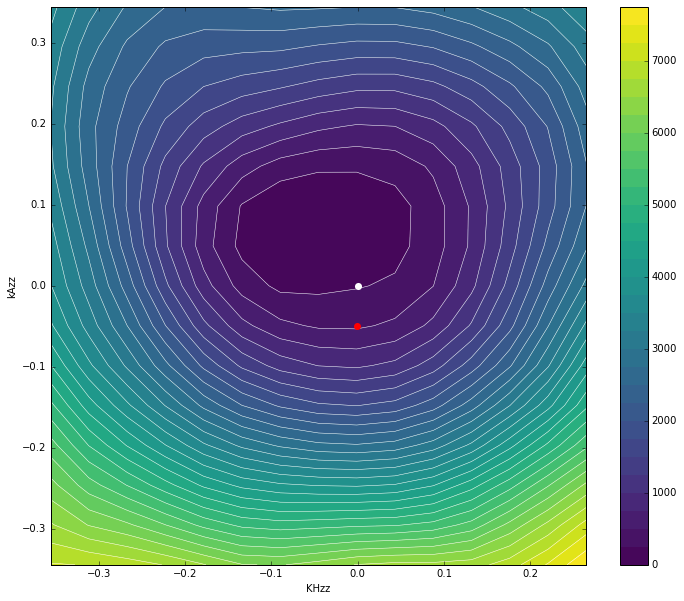

In [302]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)
from itertools import product

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

theta = np.array([x for x in product(csarray_0, csarray_1)])
llr = decomposedLikelihood.flatten()
mle = np.argmin(llr)
llr -= llr[mle]
llr *= 2.
#gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
#                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
#gp.fit(theta, llr)

#xi = np.linspace(-0.6, 0.6, 500)
#yi = np.linspace(-0.6, 0.6, 500)
xi = csarray_0    
yi = csarray_1
xx, yy = np.meshgrid(xi, yi)
print(xx.shape)
zi = decomposedLikelihood - decomposedLikelihood.min()
#zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
#zi = zz.reshape(xx.shape)

cs = plt.contour(xi, yi, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
plt.colorbar()  
#plt.scatter(theta[:, 0], theta[:, 1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([theta[mle, 0]], [theta[mle, 1]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([F1[1]], [F1[2]], marker='o', c='w', s=50, lw=0, zorder=10)
#plt.xlim(-0.6, 0.6)
#plt.ylim(-0.6, 0.6)
plt.xlim(c_min[0],c_max[0])
plt.ylim(c_min[1],c_max[1])
plt.xlabel("KHzz")
plt.ylabel("kAzz")
plt.show()

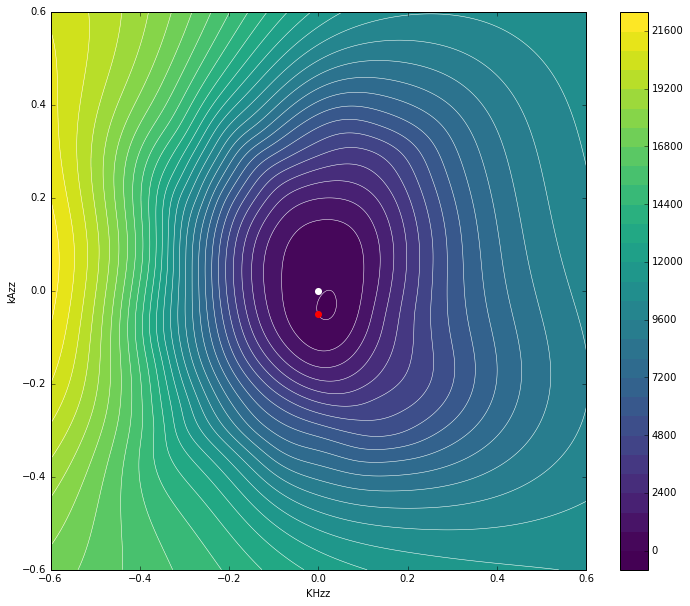

In [303]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
plt.rcParams["figure.figsize"] = (12, 10)
from itertools import product

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C, Matern

theta = np.array([x for x in product(csarray_0, csarray_1)])
llr = decomposedLikelihood.flatten()
mle = np.argmin(llr)
llr -= llr[mle]
llr *= 2.
gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(theta, llr)

xi = np.linspace(-0.6, 0.6, 500)
yi = np.linspace(-0.6, 0.6, 500)
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

cs = plt.contour(xi, yi, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
plt.colorbar()  
#plt.scatter(theta[:, 0], theta[:, 1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([theta[mle, 0]], [theta[mle, 1]], marker='o', c='r', s=50, lw=0, zorder=10)
plt.scatter([F1[1]], [F1[2]], marker='o', c='w', s=50, lw=0, zorder=10)
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel("KHzz")
plt.ylabel("kAzz")
plt.show()

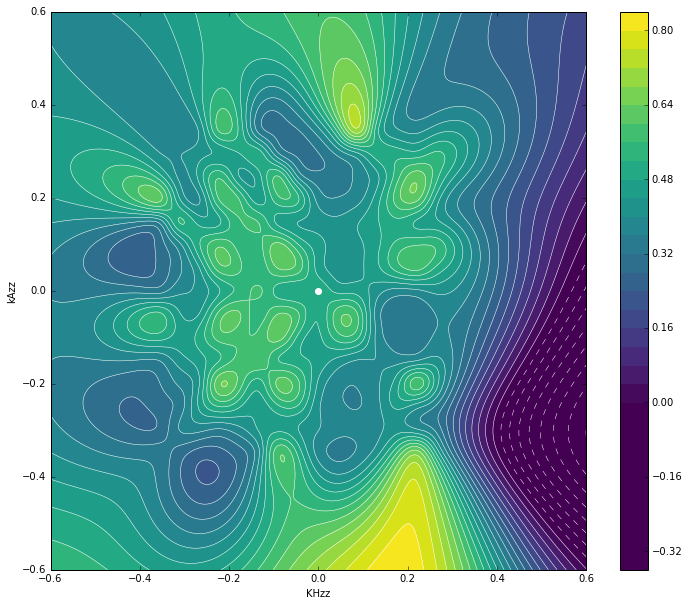

In [174]:
theta = np.array([x for x in product(csarray_0, csarray_1)])
llr = n_effs.flatten()
gp = GaussianProcessRegressor(alpha=0.0, normalize_y=True, 
                              kernel=C(1.0) * Matern(1.0, length_scale_bounds="fixed"))
gp.fit(theta, llr)

xi = np.linspace(-0.6, 0.6, 500)
yi = np.linspace(-0.6, 0.6, 500)
    
xx, yy = np.meshgrid(xi, yi)
zz, std = gp.predict(np.c_[xx.ravel(), yy.ravel()], return_std=True)
zi = zz.reshape(xx.shape)

cs = plt.contour(xi, yi, zi, 30, linewidths=0.5, colors='w')
cs = plt.contourf(xi, yi, zi, 30, cmap="viridis",
                  vmax=abs(zi).max(), vmin=0.0)
plt.colorbar()  
#plt.scatter(theta[:, 0], theta[:, 1], marker='o', c='b', s=50, lw=0, zorder=10)
plt.scatter([F1[1]], [F1[2]], marker='o', c='w', s=50, lw=0, zorder=10)
plt.xlim(-0.6, 0.6)
plt.ylim(-0.6, 0.6)
plt.xlabel("KHzz")
plt.ylabel("kAzz")
plt.show()